#### Notes

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

##### File descriptions
`train.csv` - the training set

`test.csv` - the test set

`sample_submission.csv` - a sample submission file in the correct format

##### Data fields
`id` - a unique identifier for each sentence

`text` - some text written by one of the authors

`author` - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)

A reminder about playground competitions: On Kaggle, the spirit of playground competitions is to have fun and learn together. Your score on the leaderboard doesn't earn you points, but you can still make it a rewarding competition for everyone by sharing your code in Kernels and contributing to Discussions (there are prizes for both!). In short, please don't look up the answers.

### Import libraries

In [157]:
# Load libraries #

import csv
import json

import numpy
import pandas
from matplotlib import pyplot

### Load datasets

In [158]:
# Load all data #

authored_contents = pandas.read_csv("./author detection datasets/train.csv")

unauthored_contents = pandas.read_csv("./author detection datasets/test.csv")

In [159]:
authored_contents.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [160]:
unauthored_contents.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [161]:
authored_contents.shape

(19579, 3)

### Data Exploration

In [162]:
authored_contents.describe()

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id22950,"There were sharp pains, and sudden dizziness, ...",EAP
freq,1,1,7900


In [163]:
training_records = len(authored_contents)

author_eap, author_mws, author_hpl = authored_contents.author.value_counts()

print("Total number of authored contents: ", training_records)
print("Total number of authored contents by EAP: ", author_eap)
print("Total number of authored contents by MWS: ", author_mws)
print("Total number of authored contents by HPL: ", author_hpl)

Total number of authored contents:  19579
Total number of authored contents by EAP:  7900
Total number of authored contents by MWS:  6044
Total number of authored contents by HPL:  5635


Below, we shall study the text length in the training dataset.

In [164]:
# grab text length of each contents

authored_contents['text_length'] = authored_contents['text'].str.len()

In [165]:
authored_contents.head()

,id,text,author,text_length
0,id26305,"This process, however, afforded me no means of...",EAP,231
1,id17569,It never once occurred to me that the fumbling...,HPL,71
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174


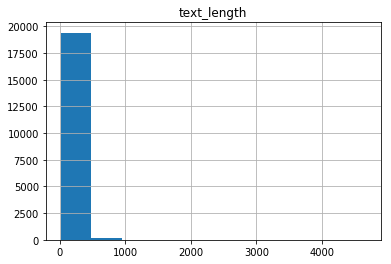

In [166]:
authored_contents.hist()
pyplot.show()

In [167]:
eap = authored_contents[authored_contents['author'] == 'EAP']['text_length']

eap.describe()

count    7900.000000
mean      142.225949
std       105.751334
min        21.000000
25%        68.000000
50%       115.000000
75%       186.000000
max      1533.000000
Name: text_length, dtype: float64

In [168]:
hpl = authored_contents[authored_contents['author'] == 'HPL']['text_length']

hpl.describe()

count    5635.000000
mean      155.843478
std        82.020647
min        21.000000
25%        98.000000
50%       142.000000
75%       196.500000
max       900.000000
Name: text_length, dtype: float64

In [169]:
mws = authored_contents[authored_contents['author'] == 'MWS']['text_length']

mws.describe()

count    6044.000000
mean      151.659828
std       126.305008
min        21.000000
25%        84.000000
50%       130.000000
75%       192.000000
max      4663.000000
Name: text_length, dtype: float64

Below, we shall study the text length in the testing dataset.

In [170]:
# examine the same in test data

testing_records = len(unauthored_contents)

unauthored_contents['text_length'] = unauthored_contents['text'].str.len()

In [171]:
unauthored_contents.head()

,id,text,text_length
0,id02310,"Still, as I urged our leaving Ireland with suc...",110
1,id24541,"If a fire wanted fanning, it could readily be ...",330
2,id00134,And when they had broken down the frail door t...,189
3,id27757,While I was thinking how I should possibly man...,223
4,id04081,I am not sure to what limit his knowledge may ...,53


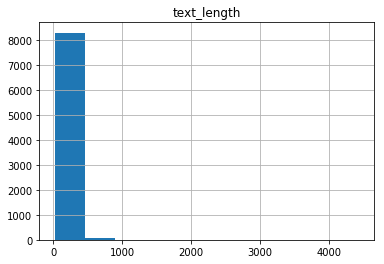

In [172]:
unauthored_contents.hist()
pyplot.show()

### Data Preprocessing

In [173]:
# binarize author in the training dataset

authored_contents['numerical_author'] = authored_contents.author.map({ 'EAP': 0, 'HPL': 1, 'MWS': 2 })

In [174]:
authored_contents.head()

,id,text,author,text_length,numerical_author
0,id26305,"This process, however, afforded me no means of...",EAP,231,0
1,id17569,It never once occurred to me that the fumbling...,HPL,71,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174,1


In [175]:
# Define labels and features set

X = authored_contents['text']
Y = authored_contents['numerical_author']

In [176]:
# author_counts = authored_contents.groupby('author').size()

# print(author_counts)

### Generate training and testing sets from the dataset

In [177]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = Y)

In [178]:
# Show the results of the split

# Features
print("Training set has " + str(X_train.shape[0]) + " features.")
print("Testing set has " + str(X_test.shape[0]) + " features.")

# Labels
print("Training set has " + str(Y_train.shape[0]) + " labels.")
print("Testing set has " + str(Y_test.shape[0]) + " labels.")

Training set has 15663 features.
Testing set has 3916 features.
Training set has 15663 labels.
Testing set has 3916 labels.


In [179]:
print(Y_train.value_counts())

print(Y_test.value_counts())

0    6320
2    4835
1    4508
Name: numerical_author, dtype: int64
0    1580
2    1209
1    1127
Name: numerical_author, dtype: int64


In [180]:
# operate the data with CountVectorizer 

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

training_vectorizer = vectorizer.transform(X_train)

In [181]:
print(len(vectorizer.get_feature_names()))

22922


In [182]:
# print(X_train)

In [183]:
# run vectorizer for X_test

testing_vectorizer = vectorizer.transform(X_test)

In [184]:
training_vectorizer

<15663x22922 sparse matrix of type '<class 'numpy.int64'>'
	with 342979 stored elements in Compressed Sparse Row format>

In [185]:
testing_vectorizer

<3916x22922 sparse matrix of type '<class 'numpy.int64'>'
	with 84298 stored elements in Compressed Sparse Row format>

As per the above transformation, training_vectorizer is our feature set.

### Parameter tuning

In [186]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

parameters = { 'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0] }

scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(mnb, parameters)

grid_fit = grid_obj.fit(training_vectorizer, Y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

grid_fit.best_params_

{'alpha': 0.5}

### Run on model

In [187]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha = 0.1)

In [188]:
mnb.fit(training_vectorizer, Y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [189]:
Y_train_prediction = mnb.predict(training_vectorizer)

In [190]:
Y_test_prediction = mnb.predict(testing_vectorizer)

In [191]:
# calculate score for predicted data against testing data
from sklearn import metrics

# compare predicted resultset with the test set
metrics.accuracy_score(Y_test, Y_test_prediction)

0.8485699693564862

In [192]:
# calculate score for predicted data against training data

metrics.accuracy_score(Y_train, Y_train_prediction)

0.9360914256528123

In [193]:
# Calculate confusion matrix

metrics.confusion_matrix(Y_test, Y_test_prediction)

array([[1323,  101,  156],
       [  94,  952,   81],
       [ 102,   59, 1048]])

In [194]:
# calculate predicted probabilities for X_test_dtm
y_pred_prob = mnb.predict_proba(testing_vectorizer)
y_pred_prob[:10]

array([[9.99805849e-01, 1.94151020e-04, 8.35058616e-13],
       [8.31143651e-01, 8.13243855e-02, 8.75319638e-02],
       [1.35134893e-02, 9.85021041e-01, 1.46546934e-03],
       [9.99910147e-01, 8.96154736e-05, 2.37228953e-07],
       [5.28653577e-01, 2.89451707e-03, 4.68451906e-01],
       [1.74354676e-12, 1.72514783e-11, 1.00000000e+00],
       [6.18080281e-09, 9.99228992e-01, 7.71001815e-04],
       [2.10788292e-10, 1.63524482e-20, 1.00000000e+00],
       [6.51545025e-07, 9.99977565e-01, 2.17839224e-05],
       [6.26344561e-03, 9.91956739e-01, 1.77981515e-03]])

### Running the prediction over `test.csv`

In [195]:
# vectorise the unauthored_contents

unpredicted_texts = unauthored_contents['text']

unpredicted_texts_vectorizer = vectorizer.transform(unpredicted_texts)

In [226]:
unpredicted_texts_vectorizer

<8392x22922 sparse matrix of type '<class 'numpy.int64'>'
	with 178310 stored elements in Compressed Sparse Row format>

In [199]:
unpredicted_texts_prediction = mnb.predict(unpredicted_texts_vectorizer)

In [204]:
# calculate predicted probabilities for X_test_dtm
predicted_prob = mnb.predict_proba(unpredicted_texts_vectorizer)
predicted_prob[:10]

array([[1.59412584e-05, 1.18876204e-05, 9.99972171e-01],
       [9.99999853e-01, 1.46702240e-07, 1.65985398e-11],
       [2.43952329e-03, 9.97560477e-01, 6.39757804e-11],
       [6.65218884e-01, 3.34781116e-01, 1.93156626e-11],
       [9.70243491e-01, 6.40666083e-03, 2.33498483e-02],
       [9.97552029e-01, 2.44784087e-03, 1.30587636e-07],
       [9.77792835e-01, 1.69316652e-02, 5.27549990e-03],
       [2.82564004e-04, 2.20083476e-03, 9.97516601e-01],
       [9.99993200e-01, 6.80023730e-06, 2.81439077e-13],
       [9.45569847e-01, 1.03455169e-02, 4.40846359e-02]])

In [215]:
unpredicted_texts_prediction

array([2, 0, 1, ..., 0, 2, 1])

In [207]:
len(unauthored_contents)

8392

In [218]:
numerical_authors = pandas.DataFrame(unpredicted_texts_prediction, columns=['num_author'])

predicted_unauthored_contents = pandas.concat([unauthored_contents, numerical_authors], axis=1)

In [223]:
predicted_unauthored_contents['author'] = predicted_unauthored_contents.num_author.map({ 0: 'EAP', 1: 'HPL', 2: 'MWS' })

In [224]:
predicted_unauthored_contents

,id,text,text_length,num_author,author
0,id02310,"Still, as I urged our leaving Ireland with suc...",110,2,MWS
1,id24541,"If a fire wanted fanning, it could readily be ...",330,0,EAP
2,id00134,And when they had broken down the frail door t...,189,1,HPL
3,id27757,While I was thinking how I should possibly man...,223,0,EAP
4,id04081,I am not sure to what limit his knowledge may ...,53,0,EAP
5,id27337,"""The thick and peculiar mist, or smoke, which ...",202,0,EAP
6,id24265,"That which is not matter, is not at all unless...",68,0,EAP
7,id25917,I sought for repose although I did not hope fo...,155,2,MWS
8,id04951,"Upon the fourth day of the assassination, a pa...",172,0,EAP
9,id14549,"""The tone metaphysical is also a good one.",42,0,EAP
